In [1]:
from math import log
import operator
import numpy as np

### 创建数据集

In [2]:
def createDataSet():
    dataset = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataset, labels

In [3]:
myDat,labels=createDataSet()
myDat,labels

([[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']],
 ['no surfacing', 'flippers'])

### 按照给定特征划分数据集

In [4]:
def splitDataSet(dataset,axis,value):
    retDataSet = []
    for featVec in dataset:
        if featVec[axis]==value:
            reduceFeatVec = featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet

- Python语言在函数中传递的是列表的引用，在函数内部对列表对象的修改会影响列表对象的整个生存周期，所以要声明一个新的列表对象。
- 按指定某个特征将数据集抽取出来

### 选择最好的数据集划分方式

#### ID3算法，利用信息增益

计算给定数据集的信息增益

In [5]:
def calShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [6]:
def chooseBestFeatureToSplit_I(dataset):
    numFeatures = len(dataset[0])-1  # 最后一个元素是标签
    baseEntropy = calShannonEnt(dataset)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataset] #取每一个特征值的所有取值
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataset, i, value)
            prob = len(subDataSet)/float(len(dataset))  #计算每一个取值的权重
            newEntropy += prob*calShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy
        if(infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

#### C4.5算法，利用信息增益比
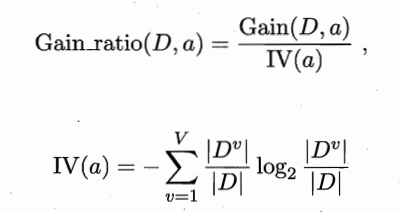

In [7]:
def chooseBestFeatureToSplit_C(dataset):
    numFeatures = len(dataset[0])-1  # 最后一个元素是标签
    baseEntropy = calShannonEnt(dataset)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataset] #取每一个特征值的所有取值
        uniqueVals = set(featList)
        newEntropy = 0.0
        splitInfo=0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataset, i, value)
            prob = len(subDataSet)/float(len(dataset))  #计算每一个取值的权重
            splitInfo-=prob*log(prob,2)
            newEntropy += prob*calShannonEnt(subDataSet)
        infoGain = float(baseEntropy - newEntropy)/splitInfo #信息增益/属性的“固有值”
        if(infoGain > bestInfoGain):
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

#### CART算法，利用基尼指数

计算给定数据集的基尼指数
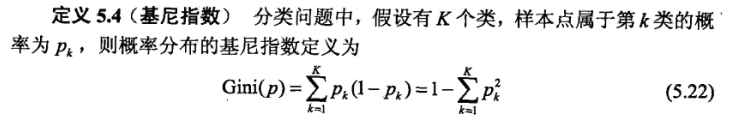

In [8]:
def calcGini(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    gini=1.0
    for key in labelCounts.keys():
        prob=float(labelCounts[key])/numEntries
        gini-=prob*prob
    return gini


In [9]:
def calcGiniWithFeat(dataSet, feature, value):
    '''
    计算给定特征下的基尼指数
    :param dataSet:数据集
    :param feature:特征维度
    :param value:该特征变量所取的值
    :return: 计算结果
    '''
    D0 = []; D1 = []
    # 根据特征划分数据
    for featVec in dataSet:
        if featVec[feature] == value:
            D0.append(featVec)
        else:
            D1.append(featVec)
    Gini = len(D0) / len(dataSet) * calcGini(D0) + len(D1) / len(dataSet) * calcGini(D1)
    return Gini


In [10]:
def chooseBestSplit_G(dataSet):
    numFeatures = len(dataSet[0])-1
    bestGini = np.inf
    bestFeat = 0
    bestValue = 0
    newGini = 0
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        for splitVal in uniqueVals:
            newGini = calcGiniWithFeat(dataSet, i, splitVal)
            if newGini < bestGini:
                bestFeat = i
                bestGini = newGini
    return bestFeat
def createCartTree(dataSet,labels):
    '''
            创建决策树
    :param: dataSet:训练数据集
    :return: labels:所有的类标签
    '''
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList): 
        return classList[0]             # 第一个递归结束条件：所有的类标签完全相同
    if len(dataSet[0]) == 1:        
        return majorityCnt(classList)   # 第二个递归结束条件：用完了所有特征
    bestFeat = chooseBestSplit_G(dataSet)   # 最优划分特征
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}         # 使用字典类型储存树的信息
#     del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]       # 复制所有类标签，保证每次递归调用时不改变原始列表的内容
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree           

In [11]:
chooseBestFeatureToSplit_I(myDat)

0

In [12]:
chooseBestFeatureToSplit_C(myDat)

0

In [13]:
chooseBestSplit_G(myDat)

0

### 递归构建决策树

In [14]:
def majorityCnt(classList):  # 返回出现次数最多的分类标签
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(
        classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]


### 创建树的函数代码

In [15]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0]  # 类别完全相同则停止继续划分
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)  # 遍历完所有特征时返回出现次数最多的
    bestFeat = chooseBestFeatureToSplit_I(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(
            splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

In [16]:
mytree = createTree(myDat,labels)

In [17]:
mytree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

### 构造注解树

In [56]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

decisionNode = dict(boxstyle="circle", color="#009900")
leafNode = dict(boxstyle="round4", color="#00CC66")
arrow_args = dict(arrowstyle="<|-",color='#999933')


def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [47]:
getNumLeafs(mytree)

3

In [20]:
getTreeDepth(mytree)

2

In [21]:
def retrieveTree(i):
    listOfTree = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}, {
        'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}]
    return listOfTree[i]

In [59]:
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center",
                        ha="center", rotation=40)


def plotTree(myTree, parentPt, nodeTxt):  # if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  # this determines the x width of this tree
    depth = getTreeDepth(myTree)
    # the text label for this node should be this
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) /
              2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        # test to see if the nodes are dictonaires, if not they are leaf nodes
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))  # recursion
        else:  # it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff,
                     plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
# if you do get a dictonary you know it's a tree, and the first element will be another dict


def createPlot(inTree, name):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)  # no ticks
    # createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.savefig(str(name))
    plt.show()

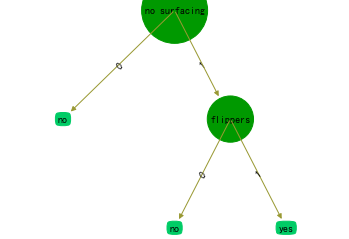

In [60]:
createPlot(mytree, 'test')

### 测试算法：使用决策树执行分类

In [24]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [25]:
myDat,labels=createDataSet()
labels

['no surfacing', 'flippers']

In [26]:
myTree=retrieveTree(0)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [27]:
classify(myTree,labels,[1,0])

'no'

In [28]:
classify(myTree,labels,[1,1])

'yes'

### 使用算法：决策树的存储

In [29]:
def storeTree(inputTree,filename):
    import pickle
    fw=open(filename,'wb')
    pickle.dump(inputTree,fw)
    fw.close()
    
def grabTree(filename):
    import pickle
    fr=open(filename,'rb')
    return pickle.load(fr)

In [30]:
storeTree(myTree,'./classifierStorage.txt')
grabTree('./classifierStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 预测隐形眼镜类型

In [31]:
fr = open('./lenses.txt')
lenses = [inst.strip().split('\t') for inst in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
fr.close()
len(lenses),lensesLabels

(24, ['age', 'prescript', 'astigmatic', 'tearRate'])

In [32]:
lenses

[['young', 'myope', 'no', 'reduced', 'no lenses'],
 ['young', 'myope', 'no', 'normal', 'soft'],
 ['young', 'myope', 'yes', 'reduced', 'no lenses'],
 ['young', 'myope', 'yes', 'normal', 'hard'],
 ['young', 'hyper', 'no', 'reduced', 'no lenses'],
 ['young', 'hyper', 'no', 'normal', 'soft'],
 ['young', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['young', 'hyper', 'yes', 'normal', 'hard'],
 ['pre', 'myope', 'no', 'reduced', 'no lenses'],
 ['pre', 'myope', 'no', 'normal', 'soft'],
 ['pre', 'myope', 'yes', 'reduced', 'no lenses'],
 ['pre', 'myope', 'yes', 'normal', 'hard'],
 ['pre', 'hyper', 'no', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'no', 'normal', 'soft'],
 ['pre', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'yes', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'normal', 'hard'],
 ['presbyopic', 

In [33]:
lensesTree = createTree(lenses, lensesLabels)
lensesTree,lensesLabels

({'tearRate': {'normal': {'astigmatic': {'yes': {'prescript': {'myope': 'hard',
       'hyper': {'age': {'presbyopic': 'no lenses',
         'young': 'hard',
         'pre': 'no lenses'}}}},
     'no': {'age': {'presbyopic': {'prescript': {'myope': 'no lenses',
         'hyper': 'soft'}},
       'young': 'soft',
       'pre': 'soft'}}}},
   'reduced': 'no lenses'}},
 ['age', 'prescript', 'astigmatic'])

In [34]:
chooseBestFeatureToSplit_C(lenses)

3

In [35]:
chooseBestFeatureToSplit_I(lenses)

3

In [36]:
chooseBestSplit_G(lenses)

3

In [37]:
# 计算预测误差 
def calcTestErr(myTree,testData,labels):
    errorCount = 0.0
    for i in range(len(testData)): 
        if classify(myTree,labels,testData[i]) != testData[i][-1]:
            errorCount += 1 
    return float(errorCount)

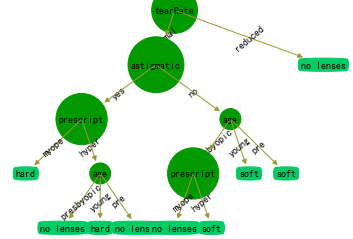

In [61]:
createPlot(lensesTree,'lenses')